In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:24pt;}
div.text_cell_render.rendered_html{font-size:20pt;}
div.text_cell_render ul li{font-size:22pt; line-height:30px;}
div.output {font-size:24pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:24pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:24pt;padding:5px;}
table.dataframe{font-size:24px;}
</style>
"""))

In [2]:
import pandas as pd
import numpy as np
import sys # 최대 정수
from tensorflow.keras.utils import to_categorical # to_categorical() : 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.models import Sequential # 모델 생성
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split # 데이터 분리

# 이진분류(로지스틱 회귀분석)
- 데이터셋 생성 & 전처리
- 엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리 -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리
- 모델 생성(입력13, 출력1) & 학습과정 설정 & 학습
- 모델 평가(그래프, 평가, 혼동행렬==교차표)
- 모델 사용

# 1. 데이터셋 생성 & 전처리
엑셀 -> 데이터프레임 -> ?처리(결측치로 전환하여 결측치처리) -> X, y분리 -> X변수의 scale 조정 -> train_test_split()이용하여 학습셋과 테스트셋분리

In [9]:
# 아나콘다 프롬프트에서 ml-dl-nlp가상환경(conda activate ml-dl-nlp)으로 간 후
# pip install openpyxl
df = pd.read_excel('data/heart-disease.xlsx', 
                   sheet_name='processed.cleveland'
                  )
df.info()
#df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [10]:
df.isin(['?']).sum()

age             0
sex             0
cp              0
treshtbps       0
chol            1
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              4
hsl             2
heartDisease    0
dtype: int64

In [11]:
# '?'가 포함된 데이터 추출 (chol, ca, hsl) : 7행
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [12]:
# ?를 결측치(np.nan)로 대체 -> 결측치 처리(삭제)
df.replace('?', np.nan, inplace=True)
df[(df['chol']=='?') | (df['ca']=='?') | (df['hsl']=='?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease


In [13]:
# 결측치가 포함된 데이터 추출
df[df.isna().any(axis=1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [14]:
# 결측치 처리:대체(fillna), 삭제(dropna)
df = df.dropna(how='any') # 결측치가 한열이라도 있으면 삭제
df.isna().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [15]:
df.shape, len(df)

((296, 14), 296)

In [16]:
# target변수의 분포가 균형을 이루는지
df['heartDisease'].value_counts() / df.shape[0] *100

0    54.054054
1    45.945946
Name: heartDisease, dtype: float64

In [17]:
# 입력(독립)변수와 타겟(종속, 출력)변수 분리
X = df.iloc[:, :-1].values # 맨마지막열을 제외한 부분을 numpy 배열
y = df.iloc[:, -1:].values # 2차원 numpy 배열(train_test_split 사용)
X.shape, y.shape

((296, 13), (296, 1))

In [18]:
X[0]

array([ 63. ,   1. ,   1. , 145. , 233. ,   1. ,   2. , 150. ,   0. ,
         2.3,   3. ,   0. ,   6. ])

In [19]:
# 입력변수 X의 스케일 조정
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X[0]

array([0.70833333, 1.        , 0.        , 0.48113208, 0.24429224,
       1.        , 1.        , 0.60305344, 0.        , 0.37096774,
       1.        , 0.        , 0.75      ])

In [24]:
# scaled_X, y를 학습셋:테스트셋 = 7:3으로 분할
x_train, x_test, y_train, y_test = train_test_split(scaled_X,
                                            y,
                                            test_size=0.3, # 테스셋이 비율
                                            random_state=7,
                                            stratify=y
                                            )

In [26]:
# 심장병 음성/양성의 비율
print(pd.DataFrame(y).value_counts(normalize=True))
print(pd.DataFrame(y_train).value_counts(normalize=True))
print(pd.DataFrame(y_test).value_counts(normalize=True))

0    0.540541
1    0.459459
dtype: float64
0    0.541063
1    0.458937
dtype: float64
0    0.539326
1    0.460674
dtype: float64


## 모델 생성(입력13, 출력1) & 학습과정 설정 & 학습
- 모델: 13->32->16->8->1
- 그래프를 보고, 과적합 줄이기 추가할 수 있음.

In [27]:
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Dense(units=32, input_dim=13, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
model.compile(loss='binary_crossentropy',
             # optimizer=Adam(learning_rate=0.01),
             optimizer='adam', 
             metrics=['accuracy', # 정확도
                     Precision(), # 정밀도(예측값 중심)
                     Recall()])   # 재현율(실제값 중심)

In [29]:
%%time
hist = model.fit(x_train, y_train, # 훈련데이터셋
                epochs=200,            #  학습횟수
                validation_split=0.2,  # 검증데이터를 훈련데이터의 20%로 사용
                verbose=0) # 간단 로그출력

Epoch 1/200
6/6 [==============================] - 1s 46ms/step - loss: 0.6929 - accuracy: 0.4909 - precision: 0.4786 - recall: 0.8590 - val_loss: 0.6953 - val_accuracy: 0.3810 - val_precision: 0.3846 - val_recall: 0.8824
Epoch 2/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6764 - accuracy: 0.4909 - precision: 0.4773 - recall: 0.8077 - val_loss: 0.6878 - val_accuracy: 0.3810 - val_precision: 0.3846 - val_recall: 0.8824
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.5212 - precision: 0.4960 - recall: 0.7949 - val_loss: 0.6803 - val_accuracy: 0.5238 - val_precision: 0.4545 - val_recall: 0.8824
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6642 - accuracy: 0.5697 - precision: 0.5289 - recall: 0.8205 - val_loss: 0.6734 - val_accuracy: 0.5714 - val_precision: 0.4815 - val_recall: 0.7647
Epoch 5/200
6/6 [==============================] - 0s 9ms/step - loss: 0.6634 - accuracy: 0.5576 - precision: 0.521

Epoch 38/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4611 - accuracy: 0.8121 - precision: 0.8852 - recall: 0.6923 - val_loss: 0.4893 - val_accuracy: 0.8095 - val_precision: 0.8000 - val_recall: 0.7059
Epoch 39/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4769 - accuracy: 0.8121 - precision: 0.8310 - recall: 0.7564 - val_loss: 0.4915 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 40/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4334 - accuracy: 0.8242 - precision: 0.8551 - recall: 0.7564 - val_loss: 0.4933 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 41/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4118 - accuracy: 0.8364 - precision: 0.8592 - recall: 0.7821 - val_loss: 0.4951 - val_accuracy: 0.8333 - val_precision: 0.7778 - val_recall: 0.8235
Epoch 42/200
6/6 [==============================] - 0s 5ms/step - loss: 0.4624 - accuracy: 0.8182 - precision: 0

Epoch 75/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3335 - accuracy: 0.8788 - precision: 0.9265 - recall: 0.8077 - val_loss: 0.4477 - val_accuracy: 0.8571 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 76/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4041 - accuracy: 0.8364 - precision: 0.8923 - recall: 0.7436 - val_loss: 0.4478 - val_accuracy: 0.8571 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 77/200
6/6 [==============================] - 0s 7ms/step - loss: 0.4164 - accuracy: 0.8424 - precision: 0.8939 - recall: 0.7564 - val_loss: 0.4492 - val_accuracy: 0.8571 - val_precision: 0.8235 - val_recall: 0.8235
Epoch 78/200
6/6 [==============================] - 0s 6ms/step - loss: 0.4077 - accuracy: 0.8303 - precision: 0.8472 - recall: 0.7821 - val_loss: 0.4429 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 79/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3666 - accuracy: 0.8788 - precision: 0

Epoch 112/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3690 - accuracy: 0.8485 - precision: 0.8841 - recall: 0.7821 - val_loss: 0.4910 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 113/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3973 - accuracy: 0.8485 - precision: 0.8841 - recall: 0.7821 - val_loss: 0.4891 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 114/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3729 - accuracy: 0.8485 - precision: 0.8841 - recall: 0.7821 - val_loss: 0.4848 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 115/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3543 - accuracy: 0.8727 - precision: 0.9385 - recall: 0.7821 - val_loss: 0.4862 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 116/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3712 - accuracy: 0.8727 - precisi

Epoch 149/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3401 - accuracy: 0.8788 - precision: 0.9265 - recall: 0.8077 - val_loss: 0.5043 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 150/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3768 - accuracy: 0.8667 - precision: 0.9118 - recall: 0.7949 - val_loss: 0.5023 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 151/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3868 - accuracy: 0.8485 - precision: 0.8841 - recall: 0.7821 - val_loss: 0.4955 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 152/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3440 - accuracy: 0.8727 - precision: 0.9385 - recall: 0.7821 - val_loss: 0.4957 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 153/200
6/6 [==============================] - 0s 6ms/step - loss: 0.3256 - accuracy: 0.8909 - precisi

Epoch 186/200
6/6 [==============================] - 0s 8ms/step - loss: 0.3056 - accuracy: 0.8727 - precision: 0.9524 - recall: 0.7692 - val_loss: 0.5085 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 187/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3369 - accuracy: 0.8485 - precision: 0.9077 - recall: 0.7564 - val_loss: 0.5038 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 188/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3136 - accuracy: 0.8667 - precision: 0.9118 - recall: 0.7949 - val_loss: 0.5075 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 189/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3283 - accuracy: 0.8727 - precision: 0.9385 - recall: 0.7821 - val_loss: 0.5094 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.7647
Epoch 190/200
6/6 [==============================] - 0s 7ms/step - loss: 0.3276 - accuracy: 0.8667 - precisi

# 3. 모델 평가(그래프, 평가, 교차표)

In [ ]:
hist.history.keys()

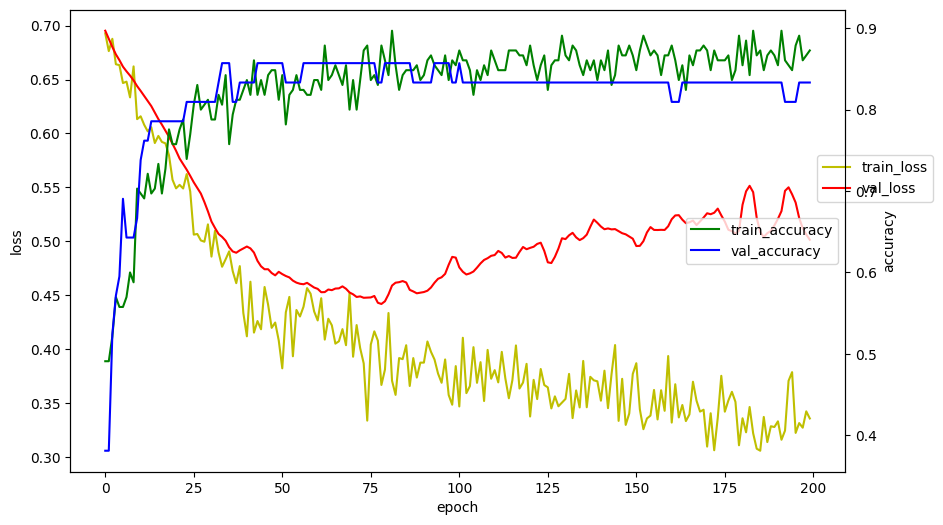

In [30]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [33]:
score = model.evaluate(x_test, y_test, verbose=0)
print('model loss :', score[0])
print('model accuracy :', score[1])
print('model precision :', score[2])
print('model recall :', score[3])

model loss : 0.542491614818573
model accuracy : 0.8202247023582458
model precision : 0.7906976938247681
model recall : 0.8292682766914368


✅ 찾은 타겟 열: 'heartDisease'

=== 데이터 전처리 ===
처리 전 데이터 shape: (303, 14)
처리 후 데이터 shape: (296, 14)
타겟 변수 'heartDisease'의 고유값: [0 1]
✅ 스케일링 성공!
Epoch 1/50
7/7 [==============================] - 1s 33ms/step - loss: 0.6906 - accuracy: 0.5797 - precision: 0.5634 - recall: 0.4167 - val_loss: 0.6898 - val_accuracy: 0.5227 - val_precision: 0.5000 - val_recall: 0.3810
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.6087 - precision: 0.6087 - recall: 0.4375 - val_loss: 0.6689 - val_accuracy: 0.5909 - val_precision: 0.6000 - val_recall: 0.4286
Epoch 3/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6465 - accuracy: 0.6618 - precision: 0.7031 - recall: 0.4688 - val_loss: 0.6509 - val_accuracy: 0.6364 - val_precision: 0.6471 - val_recall: 0.5238
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6277 - accuracy: 0.6860 - precision: 0.7246 - recall: 0.5208 - val_loss: 0.6322 - val_accuracy: 0.6591 - val_precision: 0.6875 -

7/7 [==============================] - 0s 5ms/step - loss: 0.3447 - accuracy: 0.8309 - precision: 0.8506 - recall: 0.7708 - val_loss: 0.3695 - val_accuracy: 0.8409 - val_precision: 0.8182 - val_recall: 0.8571
Epoch 38/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3420 - accuracy: 0.8309 - precision: 0.8506 - recall: 0.7708 - val_loss: 0.3683 - val_accuracy: 0.8409 - val_precision: 0.8182 - val_recall: 0.8571
Epoch 39/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3392 - accuracy: 0.8309 - precision: 0.8506 - recall: 0.7708 - val_loss: 0.3678 - val_accuracy: 0.8409 - val_precision: 0.8182 - val_recall: 0.8571
Epoch 40/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3368 - accuracy: 0.8309 - precision: 0.8506 - recall: 0.7708 - val_loss: 0.3678 - val_accuracy: 0.8409 - val_precision: 0.8182 - val_recall: 0.8571
Epoch 41/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3340 - accuracy: 0.8357 - precision: 0.8523 - recall: 0

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48337 (\N{HANGUL SYLLABLE BYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from cu

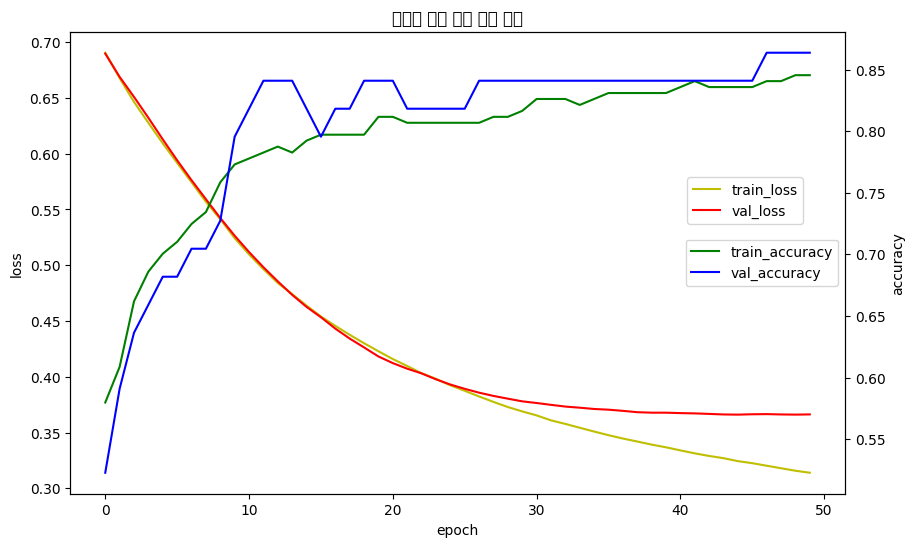


=== 모델 성능 평가 결과 ===
model loss : 0.3137
model accuracy : 0.8667
model precision : 1.0000
model recall : 0.6842
2/2 [==============================] - 0s 2ms/step

=== 혼동행렬 분석 ===
실제음성-예측음성(TN): 26 | 실제음성-예측양성(FP): 0
실제양성-예측음성(FN): 6 | 실제양성-예측양성(TP): 13

=== pandas 교차표 ===
예측값 (0:정상, 1:심장병)   0   1
실제값 (0:정상, 1:심장병)        
0                  26   0
1                   6  13

=== sklearn 혼동행렬 ===
[[26  0]
 [ 6 13]]


C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from curre

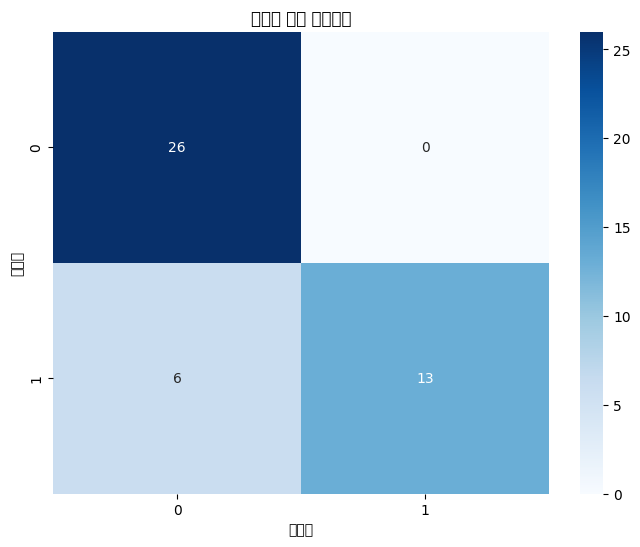

In [46]:
# 연습 문제: 교차표(혼동행렬)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 0. 데이터 파일 로드
df = pd.read_excel('data/heart-disease.xlsx')

# ✅ 수정: 'heartDisease' 추가
possible_targets = ['target', 'Target', 'HD', 'heart_disease', 'heartDisease', 'presence', 'num', 'diagnosis']
target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        print(f"✅ 찾은 타겟 열: '{target_col}'")
        break

if target_col is None:
    raise ValueError(f"❌ 타겟 열을 찾을 수 없습니다. 실제 열 이름: {df.columns.tolist()}")

# 1. 데이터 전처리
print("\n=== 데이터 전처리 ===")
print(f"처리 전 데이터 shape: {df.shape}")

# 누락값 제거
df = df.dropna()

# 비숫자형 데이터를 숫자형으로 변환
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

print(f"처리 후 데이터 shape: {df.shape}")
print(f"타겟 변수 '{target_col}'의 고유값:", df[target_col].unique())

# 특성과 타겟 분리
X = df.drop(target_col, axis=1)
y = df[target_col]

# 2. 훈련셋/검증셋/테스트셋 분리
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print("✅ 스케일링 성공!")

# 4. 모델 구축
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

# 5. 모델 학습
hist = model.fit(X_train, y_train,
                 epochs=50,
                 batch_size=32,
                 validation_data=(X_val, y_val),
                 verbose=1)

# 6. 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.title('심장병 예측 모델 학습 과정')
plt.show()

# 7. 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('\n=== 모델 성능 평가 결과 ===')
print(f'model loss : {score[0]:.4f}')
print(f'model accuracy : {score[1]:.4f}')
print(f'model precision : {score[2]:.4f}')
print(f'model recall : {score[3]:.4f}')

# 8. 예측값 생성
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# 9. 혼동행렬 수동 계산
print('\n=== 혼동행렬 분석 ===')
TN = FP = FN = TP = 0
for actual, pred in zip(y_test, y_pred.reshape(-1)):
    if actual == 0 and pred == 0:
        TN += 1
    elif actual == 0 and pred == 1:
        FP += 1
    elif actual == 1 and pred == 0:
        FN += 1
    else:
        TP += 1

print(f'실제음성-예측음성(TN): {TN} | 실제음성-예측양성(FP): {FP}')
print(f'실제양성-예측음성(FN): {FN} | 실제양성-예측양성(TP): {TP}')

# 10. pandas 교차표
ctab = pd.crosstab(y_test, y_pred.reshape(-1),
                   rownames=['실제값 (0:정상, 1:심장병)'],
                   colnames=['예측값 (0:정상, 1:심장병)'])
print('\n=== pandas 교차표 ===')
print(ctab)

# 11. sklearn 혼동행렬
print('\n=== sklearn 혼동행렬 ===')
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 12. 혼동행렬 시각화
plt.figure(figsize=(8,6))
sns.heatmap(ctab, annot=True, fmt='d', cmap='Blues')
plt.title('심장병 예측 혼동행렬')
plt.ylabel('실제값')
plt.xlabel('예측값')
plt.show()

In [ ]:
# 교차표(혼동행렬)

In [ ]:
# 모델 사용


# 분류 분석
x_train, y_train, x_test, y_test를 사용
-> y_train과 y_test 원핫인코딩